In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [8]:
donor_data = pd.read_csv('Donor Raw Data_ML with Python.csv')
prospective_donors = pd.read_csv('Prospective Donor_ML with Python.csv')

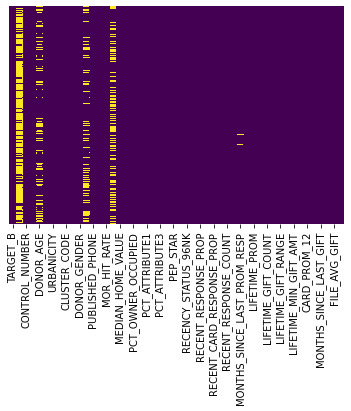

In [9]:
#Check the training data for missing values
figsize = (30,10)
sns.heatmap(donor_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')


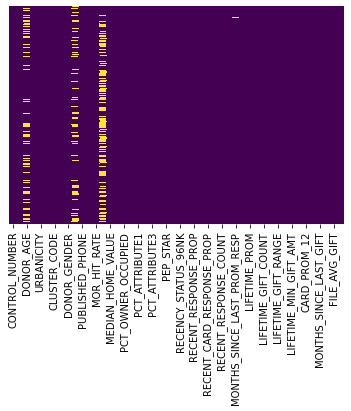

In [10]:
#check the prediction data for null values
sns.heatmap(prospective_donors.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [11]:
#Check for multi collinearity and remove feature variables that are collinear
    
# Create correlation matrix
corr_matrix = donor_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
donor_data.drop(donor_data[to_drop], axis = 1, inplace = True)
prospective_donors.drop(prospective_donors[to_drop], axis = 1, inplace = True)

In [14]:
to_drop

['MONTHS_SINCE_FIRST_GIFT', 'FILE_AVG_GIFT']

In [15]:

donor_data_dc = donor_data


#Data Cleaning

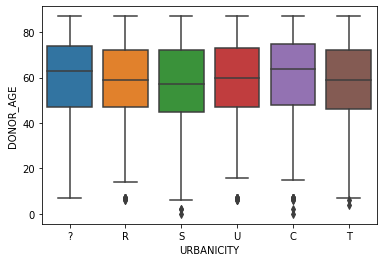

In [16]:
#Plot the variation of residence with age
sns.boxplot(data = donor_data_dc, x = 'URBANICITY', y = 'DONOR_AGE')

In [17]:
#Obtain the mean age per location
residency_means = donor_data_dc.groupby('URBANICITY')['DONOR_AGE'].mean()
residency_means

URBANICITY
?    60.169611
C    60.910872
R    58.912646
S    57.477394
T    58.488659
U    58.802180
Name: DONOR_AGE, dtype: float64

In [18]:
#fill in the missing age values in each location with the mean
for j in donor_data_dc.index:
    if pd.isnull(donor_data_dc.loc[j,'DONOR_AGE']):
        if donor_data_dc.loc[j, 'URBANICITY'] == '?':
            donor_data_dc.loc[j,'DONOR_AGE'] = 60.169611
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'C':
            donor_data_dc.loc[j,'DONOR_AGE'] = 60.910872
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'R':
            donor_data_dc.loc[j,'DONOR_AGE'] = 58.912646
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'S':
            donor_data_dc.loc[j,'DONOR_AGE'] = 57.477394
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'T':
            donor_data_dc.loc[j,'DONOR_AGE'] = 58.488659
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'U':
            donor_data_dc.loc[j,'DONOR_AGE'] = 58.802180
    
    

In [19]:
#Apply the same process to the prospective donors data
prospective_donors.groupby('URBANICITY')['DONOR_AGE'].mean()


URBANICITY
?    60.000000
C    60.988920
R    57.651877
S    56.519900
T    57.509375
U    58.056872
Name: DONOR_AGE, dtype: float64

In [20]:
for j in prospective_donors.index:
    if pd.isnull(prospective_donors.loc[j,'DONOR_AGE']):
        if prospective_donors.loc[j, 'URBANICITY'] == '?':
            prospective_donors.loc[j,'DONOR_AGE'] = 60.000000
        elif prospective_donors.loc[j, 'URBANICITY'] == 'C':
            prospective_donors.loc[j,'DONOR_AGE'] = 60.988920
        elif prospective_donors.loc[j, 'URBANICITY'] == 'R':
            prospective_donors.loc[j,'DONOR_AGE'] = 57.651877
        elif prospective_donors.loc[j, 'URBANICITY'] == 'S':
            prospective_donors.loc[j,'DONOR_AGE'] = 56.519900
        elif prospective_donors.loc[j, 'URBANICITY'] == 'T':
            prospective_donors.loc[j,'DONOR_AGE'] = 57.509375
        elif prospective_donors.loc[j, 'URBANICITY'] == 'U':
            prospective_donors.loc[j,'DONOR_AGE'] = 58.056872

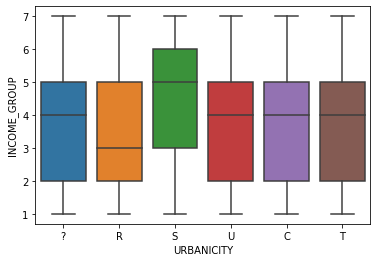

In [21]:
#Also for income group data, we use the residence to input the modal income_group by location
sns.boxplot(data = donor_data_dc, x = 'URBANICITY', y = 'INCOME_GROUP')

In [22]:
#Check the income group by location 
donor_data_dc.groupby(['URBANICITY','INCOME_GROUP'])['INCOME_GROUP'].count()

URBANICITY  INCOME_GROUP
?           1.0              30
            2.0              55
            3.0              33
            4.0              66
            5.0              74
            6.0              35
            7.0              30
C           1.0             452
            2.0             647
            3.0             335
            4.0             529
            5.0             640
            6.0             278
            7.0             281
R           1.0             507
            2.0             713
            3.0             472
            4.0             452
            5.0             539
            6.0             180
            7.0             203
S           1.0             243
            2.0             333
            3.0             324
            4.0             634
            5.0             788
            6.0             577
            7.0             566
T           1.0             318
            2.0             590
            3.0

In [23]:
for j in donor_data_dc.index:
    if pd.isnull(donor_data_dc.loc[j,'INCOME_GROUP']):
        if donor_data_dc.loc[j, 'URBANICITY'] == '?':
            donor_data_dc.loc[j,'INCOME_GROUP'] = 5
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'C':
            donor_data_dc.loc[j,'INCOME_GROUP'] = 2
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'R':
            donor_data_dc.loc[j,'INCOME_GROUP'] = 2
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'S':
            donor_data_dc.loc[j,'INCOME_GROUP'] = 5
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'T':
            donor_data_dc.loc[j,'INCOME_GROUP'] = 5
        elif donor_data_dc.loc[j, 'URBANICITY'] == 'U':
            donor_data_dc.loc[j,'INCOME_GROUP'] = 5
    
    

In [24]:
prospective_donors.groupby(['URBANICITY','INCOME_GROUP'])['INCOME_GROUP'].count()

URBANICITY  INCOME_GROUP
?           1.0              2
            2.0              7
            3.0              4
            4.0             10
            5.0              7
            6.0              6
            7.0              4
C           1.0             53
            2.0             64
            3.0             35
            4.0             65
            5.0             76
            6.0             30
            7.0             32
R           1.0             59
            2.0             70
            3.0             53
            4.0             52
            5.0             64
            6.0             22
            7.0             23
S           1.0             31
            2.0             40
            3.0             36
            4.0             73
            5.0             84
            6.0             67
            7.0             59
T           1.0             32
            2.0             61
            3.0             44
            4.

In [25]:
for j in prospective_donors.index:
    if pd.isnull(prospective_donors.loc[j,'INCOME_GROUP']):
        if prospective_donors.loc[j, 'URBANICITY'] == '?':
            prospective_donors.loc[j,'INCOME_GROUP'] = 4
        elif prospective_donors.loc[j, 'URBANICITY'] == 'C':
            prospective_donors.loc[j,'INCOME_GROUP'] = 5
        elif prospective_donors.loc[j, 'URBANICITY'] == 'R':
            prospective_donors.loc[j,'INCOME_GROUP'] = 2
        elif prospective_donors.loc[j, 'URBANICITY'] == 'S':
            prospective_donors.loc[j,'INCOME_GROUP'] = 5
        elif prospective_donors.loc[j, 'URBANICITY'] == 'T':
            prospective_donors.loc[j,'INCOME_GROUP'] = 5
        elif prospective_donors.loc[j, 'URBANICITY'] == 'U':
            prospective_donors.loc[j,'INCOME_GROUP'] = 5

In [27]:
donor_data_dc = donor_data_dc[donor_data_dc['DONOR_AGE']!=0] #remove observations with zero age values

In [28]:
#Check the skew values and pick the columns with the highest skew values
donor_data_dc.skew()

TARGET_B                        1.154631
TARGET_D                        5.169490
CONTROL_NUMBER                 -0.019447
MONTHS_SINCE_ORIGIN             0.231611
DONOR_AGE                      -0.431012
IN_HOUSE                        3.277306
INCOME_GROUP                   -0.024152
PUBLISHED_PHONE                 0.009294
MOR_HIT_RATE                   13.888793
WEALTH_RATING                  -0.178086
MEDIAN_HOME_VALUE               2.456459
MEDIAN_HOUSEHOLD_INCOME         1.723505
PCT_OWNER_OCCUPIED             -1.235567
PER_CAPITA_INCOME               3.352842
PCT_ATTRIBUTE1                 11.741241
PCT_ATTRIBUTE2                 -0.197367
PCT_ATTRIBUTE3                  0.283083
PCT_ATTRIBUTE4                  0.433831
PEP_STAR                       -0.017761
RECENT_STAR_STATUS              4.157313
FREQUENCY_STATUS_97NK           0.671895
RECENT_RESPONSE_PROP            1.364885
RECENT_AVG_GIFT_AMT             5.577441
RECENT_CARD_RESPONSE_PROP       0.771233
RECENT_AVG_CARD_

In [29]:
#columns with high skew
for_log_transform = ['MOR_HIT_RATE','MEDIAN_HOME_VALUE','MEDIAN_HOUSEHOLD_INCOME','PCT_OWNER_OCCUPIED','PER_CAPITA_INCOME','RECENT_STAR_STATUS','RECENT_RESPONSE_PROP','RECENT_AVG_GIFT_AMT','RECENT_AVG_GIFT_AMT','RECENT_RESPONSE_COUNT','MONTHS_SINCE_LAST_PROM_RESP','LIFETIME_GIFT_COUNT','LIFETIME_GIFT_AMOUNT','LIFETIME_AVG_GIFT_AMT','LIFETIME_GIFT_RANGE','LIFETIME_MAX_GIFT_AMT','LIFETIME_MIN_GIFT_AMT','LAST_GIFT_AMT','NUMBER_PROM_12','MONTHS_SINCE_LAST_GIFT','FILE_CARD_GIFT']
#columns with too many null values to be dropped
for_removal = ['TARGET_D','WEALTH_RATING']
#categorical columns to get dummy variables from
for_categorical_encoding = ['HOME_OWNER','OVERLAY_SOURCE','URBANICITY','RECENCY_STATUS_96NK','DONOR_GENDER']


In [30]:
prospective_donors.columns

Index(['CONTROL_NUMBER', 'MONTHS_SINCE_ORIGIN', 'DONOR_AGE', 'IN_HOUSE',
       'URBANICITY', 'SES', 'CLUSTER_CODE', 'HOME_OWNER', 'DONOR_GENDER',
       'INCOME_GROUP', 'PUBLISHED_PHONE', 'OVERLAY_SOURCE', 'MOR_HIT_RATE',
       'WEALTH_RATING', 'MEDIAN_HOME_VALUE', 'MEDIAN_HOUSEHOLD_INCOME',
       'PCT_OWNER_OCCUPIED', 'PER_CAPITA_INCOME', 'PCT_ATTRIBUTE1',
       'PCT_ATTRIBUTE2', 'PCT_ATTRIBUTE3', 'PCT_ATTRIBUTE4', 'PEP_STAR',
       'RECENT_STAR_STATUS', 'RECENCY_STATUS_96NK', 'FREQUENCY_STATUS_97NK',
       'RECENT_RESPONSE_PROP', 'RECENT_AVG_GIFT_AMT',
       'RECENT_CARD_RESPONSE_PROP', 'RECENT_AVG_CARD_GIFT_AMT',
       'RECENT_RESPONSE_COUNT', 'RECENT_CARD_RESPONSE_COUNT',
       'MONTHS_SINCE_LAST_PROM_RESP', 'LIFETIME_CARD_PROM', 'LIFETIME_PROM',
       'LIFETIME_GIFT_AMOUNT', 'LIFETIME_GIFT_COUNT', 'LIFETIME_AVG_GIFT_AMT',
       'LIFETIME_GIFT_RANGE', 'LIFETIME_MAX_GIFT_AMT', 'LIFETIME_MIN_GIFT_AMT',
       'LAST_GIFT_AMT', 'CARD_PROM_12', 'NUMBER_PROM_12',
       'MONTH

In [31]:
donor_data_dc.drop(for_removal, axis = 1, inplace = True)
prospective_donors.drop(['WEALTH_RATING'], axis = 1, inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
donor_data_dc.isnull().sum()

TARGET_B                         0
CONTROL_NUMBER                   0
MONTHS_SINCE_ORIGIN              0
DONOR_AGE                        0
IN_HOUSE                         0
URBANICITY                       0
SES                              0
CLUSTER_CODE                     0
HOME_OWNER                       0
DONOR_GENDER                     0
INCOME_GROUP                     0
PUBLISHED_PHONE                  0
OVERLAY_SOURCE                   0
MOR_HIT_RATE                     0
MEDIAN_HOME_VALUE                0
MEDIAN_HOUSEHOLD_INCOME          0
PCT_OWNER_OCCUPIED               0
PER_CAPITA_INCOME                0
PCT_ATTRIBUTE1                   0
PCT_ATTRIBUTE2                   0
PCT_ATTRIBUTE3                   0
PCT_ATTRIBUTE4                   0
PEP_STAR                         0
RECENT_STAR_STATUS               0
RECENCY_STATUS_96NK              0
FREQUENCY_STATUS_97NK            0
RECENT_RESPONSE_PROP             0
RECENT_AVG_GIFT_AMT              0
RECENT_CARD_RESPONSE

In [33]:
donor_data_dc = pd.get_dummies(donor_data_dc, columns=for_categorical_encoding)
prospective_donors = pd.get_dummies(prospective_donors, columns = for_categorical_encoding)

In [34]:
donor_data_dc[for_log_transform] = np.log1p(donor_data_dc[for_log_transform])
prospective_donors[for_log_transform] = np.log1p(prospective_donors[for_log_transform])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


In [35]:
donor_data_dc[for_log_transform].isnull().sum(), prospective_donors[for_log_transform].isnull().sum()

(MOR_HIT_RATE                     0
 MEDIAN_HOME_VALUE                0
 MEDIAN_HOUSEHOLD_INCOME          0
 PCT_OWNER_OCCUPIED               0
 PER_CAPITA_INCOME                0
 RECENT_STAR_STATUS               0
 RECENT_RESPONSE_PROP             0
 RECENT_AVG_GIFT_AMT              0
 RECENT_AVG_GIFT_AMT              0
 RECENT_RESPONSE_COUNT            0
 MONTHS_SINCE_LAST_PROM_RESP    254
 LIFETIME_GIFT_COUNT              0
 LIFETIME_GIFT_AMOUNT             0
 LIFETIME_AVG_GIFT_AMT            0
 LIFETIME_GIFT_RANGE              0
 LIFETIME_MAX_GIFT_AMT            0
 LIFETIME_MIN_GIFT_AMT            0
 LAST_GIFT_AMT                    0
 NUMBER_PROM_12                   0
 MONTHS_SINCE_LAST_GIFT           0
 FILE_CARD_GIFT                   0
 dtype: int64, MOR_HIT_RATE                    0
 MEDIAN_HOME_VALUE               0
 MEDIAN_HOUSEHOLD_INCOME         0
 PCT_OWNER_OCCUPIED              0
 PER_CAPITA_INCOME               0
 RECENT_STAR_STATUS              0
 RECENT_RESPONSE_PRO

In [36]:
#Remove the remaining null values
donor_data_dc.dropna(inplace = True)
prospective_donors.dropna(inplace = True)

In [37]:
#The A gender is not present in the validation (prospective_donors) data and so we drop it from the training data
donor_data_dc.drop('DONOR_GENDER_A', axis = 1, inplace = True)

In [38]:
#There were non numeric values such as ? and . in the training and validation datasets, so we drop them too
donor_data_dc.drop(donor_data_dc.index[donor_data_dc['CLUSTER_CODE']==' .'], inplace = True)
prospective_donors.drop(prospective_donors.index[prospective_donors['CLUSTER_CODE']==' .'], inplace = True)

In [39]:
donor_data_dc.set_index('CONTROL_NUMBER', inplace = True)
prospective_donors.set_index('CONTROL_NUMBER', inplace = True)

#scaling the data and building models to predict
#For this problem, I think the recall is the really important metric (TP/TP+FN) because we need to identify the individuals that donated in the training set

In [40]:
def scale_and_predict(donor_data_dc, model):
    """
    description: the function takes in a dataset and a model, then performs a 
                    train test split as well as minmax scaling before trainign a model
                    on the split and scaled data
    args:       donor_data_dc: the dataset
                    model: model to be used
    output:     recall_score: The recall (True Positive/True Positives+ False Negatives)
    """
    X_train, X_test, y_train, y_test = train_test_split(donor_data_dc.drop('TARGET_B', axis = 1), donor_data_dc['TARGET_B'], test_size=0.25, random_state=42)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    logmodel = model
    logmodel.fit(X_train,y_train)
    predictions = logmodel.predict(X_test)
    print(classification_report(y_test,predictions))
    print(confusion_matrix(y_test, predictions))
    return recall_score(y_test, predictions)

In [47]:
#create a list of models to test
models_to_test = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier(), AdaBoostClassifier(), SVC()]

In [48]:
recall_scores=[]
for j in models_to_test:
    recall = scale_and_predict(donor_data_dc, j)
    recall_scores.append(recall)
recall_scores


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.99      0.86      3521
           1       0.46      0.02      0.03      1147

    accuracy                           0.75      4668
   macro avg       0.61      0.50      0.44      4668
weighted avg       0.68      0.75      0.66      4668

[[3500   21]
 [1129   18]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      3521
           1       0.29      0.32      0.31      1147

    accuracy                           0.64      4668
   macro avg       0.53      0.53      0.53      4668
weighted avg       0.65      0.64      0.65      4668

[[2646  875]
 [ 783  364]]


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.96      0.85      3521
           1       0.36      0.08      0.13      1147

    accuracy                           0.74      4668
   macro avg       0.56      0.52      0.49      4668
weighted avg       0.66      0.74      0.67      4668

[[3363  158]
 [1057   90]]
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      3521
           1       0.65      0.03      0.06      1147

    accuracy                           0.76      4668
   macro avg       0.70      0.51      0.46      4668
weighted avg       0.73      0.76      0.66      4668

[[3502   19]
 [1112   35]]
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      3521
           1       0.51      0.04      0.07      1147

    accuracy                           0.75      4668
   macro avg       0.63      0.51      0.47      4668
weighted avg       0

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3521
           1       0.00      0.00      0.00      1147

    accuracy                           0.75      4668
   macro avg       0.38      0.50      0.43      4668
weighted avg       0.57      0.75      0.65      4668

[[3521    0]
 [1147    0]]


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.015693112467306015,
 0.31734960767218834,
 0.07846556233653008,
 0.03051438535309503,
 0.04010462074978204,
 0.0]

A decision tree classifier gave the best recall score of 0.3. This score can be improved by undersampling to remove the bias towards the negative class in the dataset

In [43]:
def under_sample(donor_data_clean):
    """
    description: This function undersamples the provided dataset by randomly 
                 selecting a number of positive values equal to the number of 
                 negative values in the target column and discarding the remaining
                 negative observations
    input:       donor_data_clean: the data to be undersampled
    output:      underSampling: the undersampled data
    """
    donated = donor_data_clean[donor_data_clean['TARGET_B']==1]
    nonDonate = donor_data_clean[donor_data_clean['TARGET_B']==0]
    donor_count = donor_data_clean['TARGET_B'].value_counts()[1]
    randomSelection = nonDonate.sample(donor_count)
    underSampling = pd.concat([donated, randomSelection])
    return underSampling

def undersample_train(donor_data_clean, model):
    """
    description: This function applies the under_sample function to the input dataset,
                 splits it into train and test, scales it and carries out training and prediction using 
                 the indicated model
    input:       donor_data_clean: the data to be undersampled
                 model: model to be trained and predicted with
    output:      log_new_model: the trained model
    """
    
    X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(donor_data_clean, donor_data_clean['TARGET_B'], test_size=0.2, random_state=42)
    X_new_train = under_sample(X_new_train)
    y_new_train = X_new_train['TARGET_B']
    X_new_train = X_new_train.drop('TARGET_B', axis = 1).values
    X_new_test = X_new_test.drop('TARGET_B', axis = 1).values

    scaler = MinMaxScaler()
    scaler.fit(X_new_train)
    X_new_train = scaler.transform(X_new_train)
    X_new_test = scaler.transform(X_new_test)
    log_new_model = model
    log_new_model.fit(X_new_train, y_new_train)
    predictions = log_new_model.predict(X_new_test)
    print(classification_report(y_new_test,predictions))
    print(confusion_matrix(y_new_test, predictions))
    return log_new_model

In [44]:
decision_tree_model = undersample_train(donor_data_dc, DecisionTreeClassifier())


              precision    recall  f1-score   support

           0       0.77      0.54      0.63      2829
           1       0.26      0.51      0.34       905

    accuracy                           0.53      3734
   macro avg       0.52      0.52      0.49      3734
weighted avg       0.65      0.53      0.56      3734

[[1523 1306]
 [ 447  458]]


Apply the Model and create a list of control numbers for the most likely prospects to donate

In [45]:
donor_predictions = decision_tree_model.predict(prospective_donors)
prospective_donors.insert(0, "TARGET_PRED", list(donor_predictions), True)
prospective_donors = prospective_donors.reset_index()
list_of_likely_donors = prospective_donors[['CONTROL_NUMBER', 'TARGET_PRED']][prospective_donors['TARGET_PRED']==1]
prospective_donors[['CONTROL_NUMBER', 'TARGET_PRED']][prospective_donors['TARGET_PRED']==1]

,CONTROL_NUMBER,TARGET_PRED
1,142,1
3,368,1
4,387,1
8,702,1
9,743,1
...,...,...
2055,190177,1
2056,190267,1
2057,190412,1
2062,190778,1
